In [29]:
import os
import math
import numpy as np
import pyopencl as cl
import pyopencl.array
import time
from PIL import Image, ImageEnhance, ImageFilter
from matplotlib import cm

TASKS = 1048576
CL_TASKS = int(TASKS / 4)

In [30]:
filename = "./6_shapes.png"
img = Image.open(filename)
# img = img.filter(ImageFilter.GaussianBlur(radius = 0.5)) 
if img.mode != "RGBA":
    img = img.convert("RGBA")
img_width = img.size[0]
img_height = img.size[1]
img_size = img_width * img_height

print("Image size: %d x %d" % (img_width, img_height))

Image size: 718 x 266


In [31]:
platforms = cl.get_platforms()
print(platforms)
my_gpu_devices = platforms[0].get_devices(device_type=cl.device_type.GPU)
print(my_gpu_devices)
ctx = cl.Context(devices=my_gpu_devices)
# ctx = cl.create_some_context()
print(ctx)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

[<pyopencl.Platform 'NVIDIA CUDA' at 0x220055b5160>, <pyopencl.Platform 'Intel(R) OpenCL HD Graphics' at 0x220151d4600>]
[<pyopencl.Device 'NVIDIA GeForce GTX 1060' on 'NVIDIA CUDA' at 0x220055b3fe0>]
<pyopencl.Context at 0x22005092d60 on <pyopencl.Device 'NVIDIA GeForce GTX 1060' on 'NVIDIA CUDA' at 0x220055b3fe0>>


In [32]:
# read kernel from files
kernels = ""
for file in os.listdir(f"./"):
    if file.endswith(".cl"):
        f = open(f"./{file}", "r", encoding="utf-8")
        kernels += "".join(f.readlines())
        f.close()
prg = cl.Program(ctx, kernels).build()

In [33]:
## to_blur

image_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)

# prepare device memory for OpenCL
input_buf_1 = cl.Image(
    ctx,
    cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR,
    image_format,
    img.size,
    None,
    img.tobytes(),
)
dest_buf_1 = cl.Image(ctx, cl.mem_flags.READ_WRITE, image_format, img.size)

# run kernel
mask_size = 0
np_mask_size = np.int32(mask_size)
# prg.to_blur(queue, (img_size,), (1,), dest_buf_1, input_buf_1, np_mask_size).wait()

# # read image back to cpu
# dest = numpy.zeros(img_width * img_height * 4, numpy.uint8)
# cl.enqueue_copy(
#     queue, dest=dest, src=dest_buf_1, origin=(0, 0), region=(img_width, img_height)
# ).wait()


## to_gray

# dest_buf_2 = cl.Image(ctx, cl.mem_flags.READ_WRITE, image_format, img.size)
dest_buf_2 = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)

prg.to_gray_buffer(queue, (img_width, img_height), (1, 1), dest_buf_2, input_buf_1).wait()

# read image back to cpu
# dest = np.zeros(img_width * img_height * 4, np.uint8)
# cl.enqueue_copy(
#     queue, dest=dest, src=dest_buf_2, origin=(0, 0), region=(img_width, img_height)
# ).wait()
dest = np.zeros(img_width * img_height, np.float32)
cl.enqueue_copy(
    queue,
    dest=dest,
    src=dest_buf_2,
    buffer_origin=(0,),
    host_origin=(0,),
    region=(img_width * img_height * np.dtype(np.float32).itemsize,),
).wait()

## blur 2
dest_buf_3 = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)

# prg.gaussian_blur_separable_2d_buffer(queue, (img_width, img_height), (1, 1), dest_buf_3, dest_buf_2, 1,10,1).wait()
prg.to_blur_buffer(queue, (img_width, img_height), (1, 1), dest_buf_3, dest_buf_2, np_mask_size).wait()

# read image back to cpu
# dest = np.zeros(img_width * img_height, np.float32)
# cl.enqueue_copy(
#     queue,
#     dest=dest,
#     src=dest_buf_3,
#     buffer_origin=(0,),
#     host_origin=(0,),
#     region=(img_width * img_height * np.dtype(np.float32).itemsize,),
# ).wait()


## gradient

dx = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)
dy = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)
dxx = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)
dxy = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)
dyx = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize) # redundant
dyy = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)

prg.gradient_x_2d_buffer(queue, (img_width, img_height), (1, 1), dx, dest_buf_3).wait()
prg.gradient_y_2d_buffer(queue, (img_width, img_height), (1, 1), dy, dest_buf_3).wait()
prg.gradient_x_2d_buffer(queue, (img_width, img_height), (1, 1), dxx, dx).wait()
prg.gradient_y_2d_buffer(queue, (img_width, img_height), (1, 1), dxy, dx).wait()
prg.gradient_x_2d_buffer(queue, (img_width, img_height), (1, 1), dyx, dy).wait() # redundant
prg.gradient_y_2d_buffer(queue, (img_width, img_height), (1, 1), dyy, dy).wait()

# read image back to cpu
# dest = np.zeros(img_width * img_height, np.float32)
# cl.enqueue_copy(
#     queue,
#     dest=dest,
#     src=dxx,
#     buffer_origin=(0,),
#     host_origin=(0,),
#     region=(img_width * img_height * np.dtype(np.float32).itemsize,),
# ).wait()


h = cl.Buffer(ctx, cl.mem_flags.READ_WRITE, img_width * img_height * np.dtype(np.float32).itemsize)

prg.mean_curvature(queue, (img_width, img_height), (1, 1), h, dx, dy, dxx, dxy, dyy).wait()

# read image back to cpu
dest = np.zeros(img_width * img_height, np.float32)
cl.enqueue_copy(
    queue,
    dest=dest,
    src=h,
    buffer_origin=(0,),
    host_origin=(0,),
    region=(img_width * img_height * np.dtype(np.float32).itemsize,),
).wait()

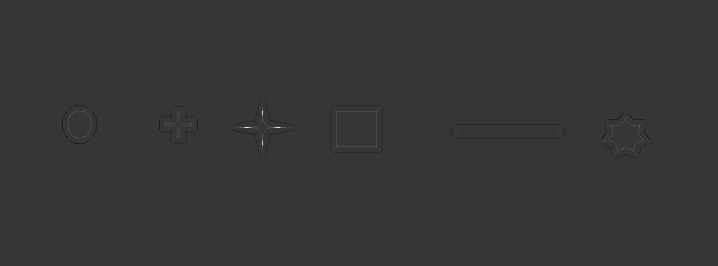

In [34]:
# # for buffer
dest = np.reshape(dest, (img_height, img_width))
# display(dest)
# normalize all values to be between 0 and 1
dest2 = (dest-np.min(dest))/(np.max(dest)-np.min(dest))
# clamp all values to be between
# dest2 = np.clip(dest2, 0, 0.3)
# set threshold
# dest2[dest2 >= 0.85] = 1
# dest2[dest2 <= 0.85] = 0

# display(dest2)
out_img = Image.fromarray(np.uint8(cm.Greys(dest2)*255)) # plasma, inferno, magma, viridis, Greys

# # for image
# out_img = Image.frombytes("RGBA", img.size, dest.tobytes())

if out_img.mode == "RGBA":
    out_img = out_img.convert("RGB")

# enhancer = ImageEnhance.Brightness(out_img)
# enhancer = ImageEnhance.Contrast(out_img)
# to reduce brightness by 50%, use factor 0.5
# out_img = enhancer.enhance(0.50)
# out_im.save("out.png")
display(out_img)